# Human Genome Language Model

This notebook trains a language model on the human genome, using data prepared in the Data Processing notebook. The language model trained is based on the AWD-LSTM architecture. The genomic input information is split into 4-mers with a stride of 2 bases between each 4-mer. The model is trained to take an input sequence of 4-mers and predict the next 4-mer. This allows us to train a model that learns the structure of genomic information in a totally unsupervised way.

The base of the language model (token embedding + LSTM layers) will then be used to initialize a classification model.

For more detail on how genomic data is processed and how these language models are trained, see the following notebooks:

[E. coli 1 Naive Model](https://github.com/kheyer/Genomic-ULMFiT/blob/master/Bacteria/E.%20Coli/E.%20coli%201%20Naive%20Model.ipynb)

[E. coli 2 Genomic Pretraining](https://github.com/kheyer/Genomic-ULMFiT/blob/master/Bacteria/E.%20Coli/E.%20coli%202%20Genomic%20Pretraining.ipynb)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.text import *
from Bio import Seq
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.SeqFeature import FeatureLocation, CompoundLocation
import networkx as nx

In [3]:
sys.path.append("../../..")
from utils import *

In [4]:
path = Path('F:/genome/human/')

In [5]:
df_iter = pd.read_csv(path/'human_genome_data_fa.csv', chunksize=220000)

In [6]:
df = next(df_iter)

In [7]:
df_val = df[:20000]

In [8]:
tok = Tokenizer(partial(GenomicTokenizer, ngram=5, stride=1), n_cpus=1, pre_rules=[], post_rules=[], special_cases=['xxpad'])

In [9]:
data = GenomicTextLMDataBunch.from_df(path, df[20000:], df_val, bs=800, tokenizer=tok, 
                              chunksize=10000, text_cols=0, label_cols=1, max_vocab=80000)

In [10]:
len(data.vocab.stoi), len(data.vocab.itos)

(1025, 1025)

In [11]:
np.save(path/'human_vocab_5m1s.npy', data.vocab.itos)

In [12]:
voc = np.load(path/'human_vocab_5m1s.npy')
model_vocab = GenomicVocab(voc)

In [11]:
data = GenomicTextLMDataBunch.from_df(path, df[20000:], df_val, bs=800, tokenizer=tok, vocab=model_vocab, max_vocab=80000,
                              chunksize=10000, text_cols=0, label_cols=1)

In [12]:
len(data.vocab.itos), len(data.vocab.stoi)

(257, 257)

In [15]:
config = dict(emb_sz=400, n_hid=1150, n_layers=3, pad_token=0, qrnn=False, output_p=0.25, 
                          hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15, tie_weights=True, out_bias=True)
drop_mult=0.3

In [16]:
learn = get_model_LM(data, drop_mult, config)

In [17]:
learn = learn.to_fp16(dynamic=True);

In [18]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(1025, 400, padding_idx=0)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(1025, 400, padding_idx=0)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=1025, bias=True)
    (output_dp): RNNDropout()
  )
)

In [20]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


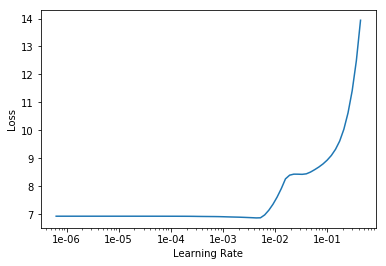

In [21]:
learn.recorder.plot()

In [22]:
learn.fit_one_cycle(2, 5e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.193925,1.146591,0.463819,1:15:11
1,1.170603,1.123467,0.475602,1:14:44


In [23]:
learn.save('human_5m1s')
learn.save_encoder('human_5m1s_enc')

In [27]:
learn.load('human_5m1s');

In [24]:
voc = np.load(path/'human_vocab_5m1s.npy')
model_vocab = GenomicVocab(voc)

In [25]:
count = 0
lr = 5e-3
for df in df_iter:
    data = GenomicTextLMDataBunch.from_df(path, df, df_val, bs=800, tokenizer=tok, vocab=model_vocab, max_vocab=80000,
                                  chunksize=10000, text_cols=0, label_cols=1)
    learn.data = data
    lr_iter = lr/1.5**count
    print(f'Learning Rate: {lr_iter}')
    learn.fit_one_cycle(2, lr, moms=(0.8,0.7))
    count += 1

Learning Rate: 0.005


epoch,train_loss,valid_loss,accuracy,time
0,1.185816,1.133367,0.470042,1:21:44
1,1.147864,1.115243,0.480477,1:21:43


Learning Rate: 0.0033333333333333335


epoch,train_loss,valid_loss,accuracy,time
0,1.139578,1.119984,0.477896,1:21:10
1,1.115624,1.103820,0.488018,1:21:32


Learning Rate: 0.0022222222222222222


epoch,train_loss,valid_loss,accuracy,time
0,1.132733,1.104742,0.488734,1:21:31
1,1.115497,1.090791,0.497934,1:21:32


Learning Rate: 0.0014814814814814814


epoch,train_loss,valid_loss,accuracy,time
0,1.110533,1.096240,0.494859,1:21:14
1,1.094542,1.084768,0.502285,1:21:18


Learning Rate: 0.0009876543209876543


epoch,train_loss,valid_loss,accuracy,time
0,1.070056,1.090482,0.499050,1:21:28
1,1.054996,1.079369,0.506076,1:20:59


Learning Rate: 0.0006584362139917696


epoch,train_loss,valid_loss,accuracy,time
0,1.049337,1.088022,0.500237,54:49
1,1.037767,1.078975,0.506368,55:14


In [26]:
learn.save('human_5m1s2')
learn.save_encoder('human_5m1s_enc2')